In [153]:
# Load the MacroHFT dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
from pandas.plotting import autocorrelation_plot

Dataset shape: (220320, 71)
Available columns: ['timestamp' 'ask1_price' 'ask1_size' 'bid1_price' 'bid1_size'
 'ask2_price' 'ask2_size' 'bid2_price' 'bid2_size' 'ask3_price'
 'ask3_size' 'bid3_price' 'bid3_size' 'ask4_price' 'ask4_size'
 'bid4_price' 'bid4_size' 'ask5_price' 'ask5_size' 'bid5_price'
 'bid5_size' 'volume' 'bid1_size_n' 'bid2_size_n' 'bid3_size_n'
 'bid4_size_n' 'bid5_size_n' 'ask1_size_n' 'ask2_size_n' 'ask3_size_n'
 'ask4_size_n' 'ask5_size_n' 'wap_1' 'wap_2' 'wap_balance' 'buy_spread'
 'sell_spread' 'buy_volume' 'sell_volume' 'volume_imbalance'
 'price_spread' 'sell_vwap' 'buy_vwap' 'log_return_bid1_price'
 'log_return_bid2_price' 'log_return_ask1_price' 'log_return_ask2_price'
 'log_return_wap_1' 'log_return_wap_2' 'ask1_price_trend_60'
 'bid1_price_trend_60' 'buy_spread_trend_60' 'sell_spread_trend_60'
 'wap_1_trend_60' 'wap_2_trend_60' 'buy_vwap_trend_60'
 'sell_vwap_trend_60' 'volume_trend_60' 'open' 'high' 'low' 'close' 'kmid'
 'klen' 'kmid2' 'kup' 'kup2' 'klow' 

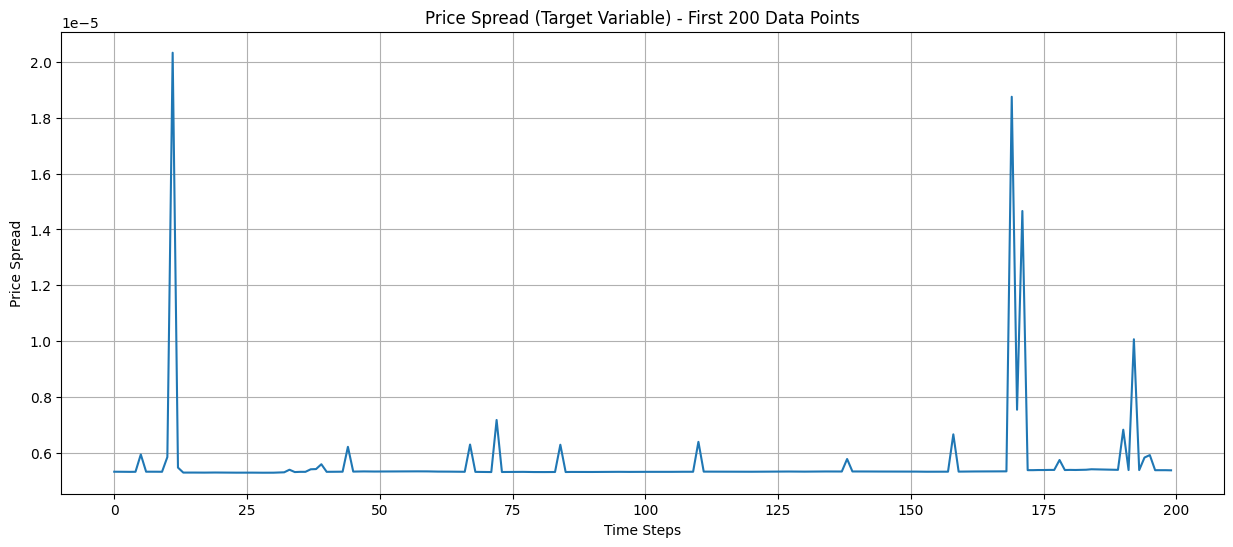

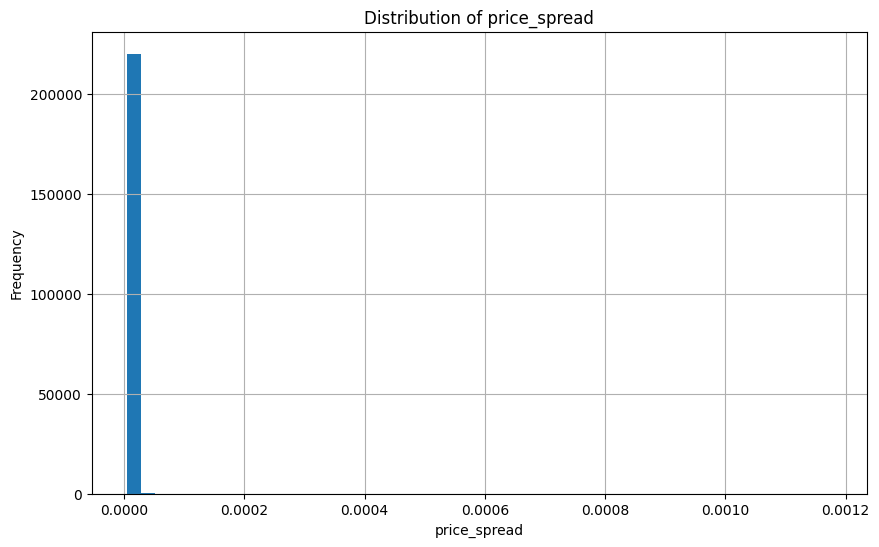

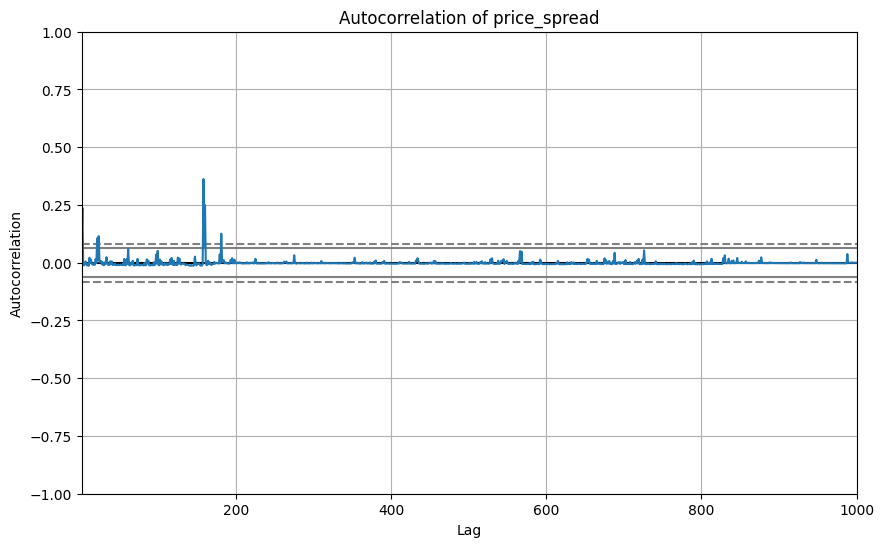

In [154]:
# Load the dataset
df = pd.read_feather("data_1/ETHUSDT/df_test.feather")

# Analyze the dataset
print("Dataset shape:", df.shape)
print("Available columns:", df.columns.values)
print("Sample data:\n", df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values[missing_values > 0])

# Handle missing values if any
if df.isnull().sum().sum() > 0:
    df = df.fillna(df.median())

# Visualize the target variable (price_spread)
plt.figure(figsize=(15, 6))
plt.plot(df['price_spread'].values[:200])
plt.title('Price Spread (Target Variable) - First 200 Data Points')
plt.xlabel('Time Steps')
plt.ylabel('Price Spread')
plt.grid(True)
plt.show()

# Show the distribution of the target variable
plt.figure(figsize=(10, 6))
plt.hist(df['price_spread'], bins=50)
plt.title('Distribution of price_spread')
plt.xlabel('price_spread')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Show autocorrelation of the target variable
plt.figure(figsize=(10, 6))
autocorrelation_plot(df['price_spread'].values[:1000])
plt.title('Autocorrelation of price_spread')
plt.grid(True)
plt.show()


Selected features: ['open', 'high', 'low', 'close', 'volume']


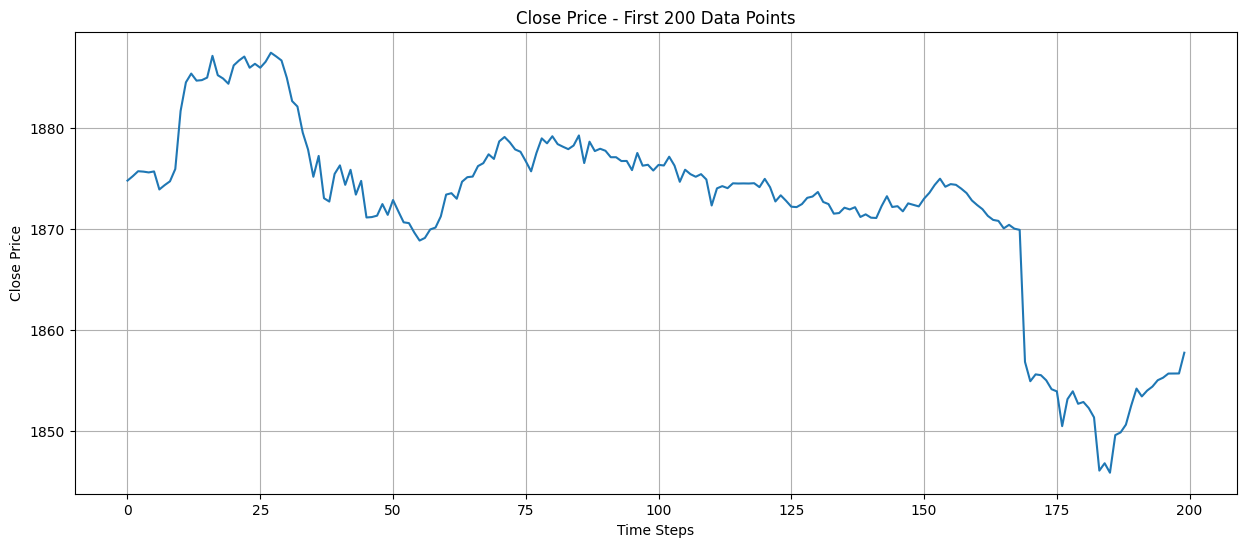

In [155]:
# Select top 10 features (excluding the target itself)
selected_features = [
    'open',
    'high',
    'low',
    'close',
    'volume',
]
target_column = 'close'

print("Selected features:", selected_features)

# Extract features and target
X = df[selected_features].values
y = df[target_column].values.reshape(-1, 1)

# Normalize the data
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# X_scaled = X_scaler.fit_transform(X)
# y_scaled = y_scaler.fit_transform(y)

# Show the distribution of normalized target
plt.figure(figsize=(15, 6))
plt.plot(df['close'].values[:200])  # Changed to 'close'
plt.title('Close Price - First 200 Data Points')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()


In [156]:
# Split data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

X_train = X_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)

X_test = X_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")

# Create sequences for LSTM
def create_sequences(x, y, time_steps=30):
    """
    Create sequences of data suitable for LSTM training
    Args:
        x: Features array (samples × features)
        y: Target array (samples × 1)
        time_steps: Number of time steps to look back
    
    Returns:
        X_seq: Sequence of features (samples × time_steps × features)
        y_seq: Target values (samples × 1)
    """
    X_seq, y_seq = [], []
    for i in range(len(x) - time_steps):
        X_seq.append(x[i:(i + time_steps)])
        y_seq.append(y[i + time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 30  # Look back 30 time steps
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

print(f"Training sequences shape: X={X_train_seq.shape}, y={y_train_seq.shape}")
print(f"Testing sequences shape: X={X_test_seq.shape}, y={y_test_seq.shape}")

# Create PyTorch datasets and loaders
batch_size = 64

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training data shape: X=(176256, 5), y=(176256, 1)
Testing data shape: X=(44064, 5), y=(44064, 1)
Training sequences shape: X=(176226, 30, 5), y=(176226, 1)
Testing sequences shape: X=(44034, 30, 5), y=(44034, 1)


In [157]:
import torch.nn as nn
import torch.optim as optim

class VanillaLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(VanillaLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = len(selected_features)  # Number of features
hidden_size = 64
output_size = 1

# Create the model
model = VanillaLSTM(input_size, hidden_size, output_size)
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


VanillaLSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


Using device: cpu
Epoch [1/20], Train Loss: 0.001284, Test Loss: 0.000051
Epoch [2/20], Train Loss: 0.000071, Test Loss: 0.000051
Epoch [3/20], Train Loss: 0.000062, Test Loss: 0.000033
Epoch [4/20], Train Loss: 0.000059, Test Loss: 0.000037
Epoch [5/20], Train Loss: 0.000055, Test Loss: 0.000034
Epoch [6/20], Train Loss: 0.000053, Test Loss: 0.000035
Epoch [7/20], Train Loss: 0.000052, Test Loss: 0.000066
Epoch [8/20], Train Loss: 0.000054, Test Loss: 0.000059
Epoch [9/20], Train Loss: 0.000052, Test Loss: 0.000028
Epoch [10/20], Train Loss: 0.000052, Test Loss: 0.000050
Epoch [11/20], Train Loss: 0.000051, Test Loss: 0.000036
Epoch [12/20], Train Loss: 0.000051, Test Loss: 0.000033
Epoch [13/20], Train Loss: 0.000050, Test Loss: 0.000050
Epoch [14/20], Train Loss: 0.000050, Test Loss: 0.000056
Epoch [15/20], Train Loss: 0.000050, Test Loss: 0.000030
Epoch [16/20], Train Loss: 0.000048, Test Loss: 0.000081
Epoch [17/20], Train Loss: 0.000049, Test Loss: 0.000041
Epoch [18/20], Train L

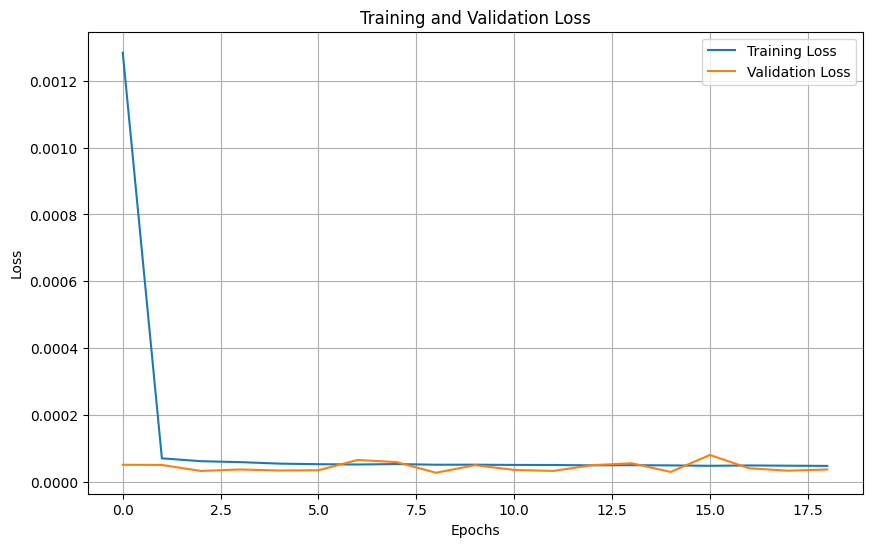

In [158]:
# Training function with early stopping
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=100, early_stopping_patience=10):
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move model to device
    model.to(device)
    
    # Lists to store metrics
    train_losses = []
    test_losses = []
    
    # Early stopping variables
    min_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # Move data to device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                # Move data to device
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                # Forward pass
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
        
        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.6f}, '
              f'Test Loss: {avg_test_loss:.6f}')
        
        # Early stopping check
        if avg_test_loss < min_val_loss:
            min_val_loss = avg_test_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    # Load the best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return model, train_losses, test_losses

# Train the model
trained_model, train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    num_epochs=20,
    early_stopping_patience=10
)


Mean Squared Error (MSE): 9.080007
Root Mean Squared Error (RMSE): 3.013305
Mean Absolute Error (MAE): 2.190837
R² Score: 0.998942


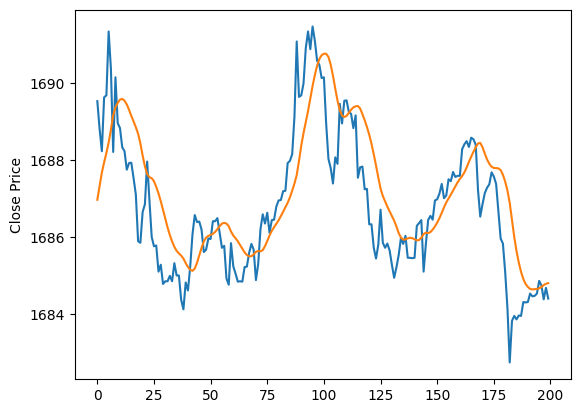

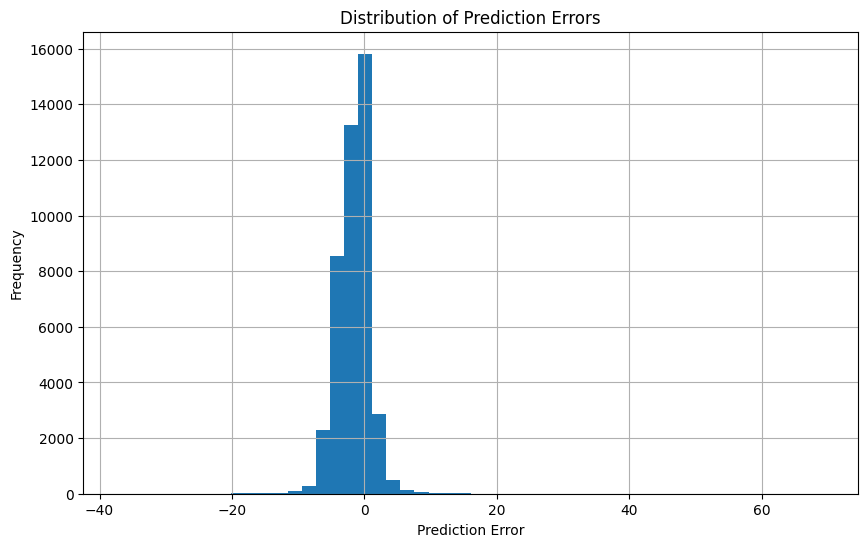

In [159]:
# Evaluate the model
def evaluate_model(model, X_test_tensor, y_test_tensor, y_scaler):
    # Set model to evaluation mode
    model.eval()
    
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    X_test_tensor = X_test_tensor.to(device)
    
    # Make predictions
    with torch.no_grad():
        y_pred_scaled = model(X_test_tensor).cpu().numpy()
    
    # Inverse transform to get actual values
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    y_actual = y_scaler.inverse_transform(y_test_tensor.numpy())
    
    # Calculate metrics
    mse = mean_squared_error(y_actual, y_pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)
    
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.6f}")
    
    # Plot actual vs predicted values
    plt.plot(y_actual[:200], label='Actual Close')  # Updated labels
    plt.plot(y_pred[:200], label='Predicted Close')
    plt.ylabel('Close Price')
    
    # Plot the distribution of prediction errors
    errors = y_actual - y_pred
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)
    plt.show()
    
    return y_pred, y_actual, mse, rmse, mae, r2

# Evaluate the trained model
y_pred, y_actual, mse, rmse, mae, r2 = evaluate_model(trained_model, X_test_tensor, y_test_tensor, y_scaler)


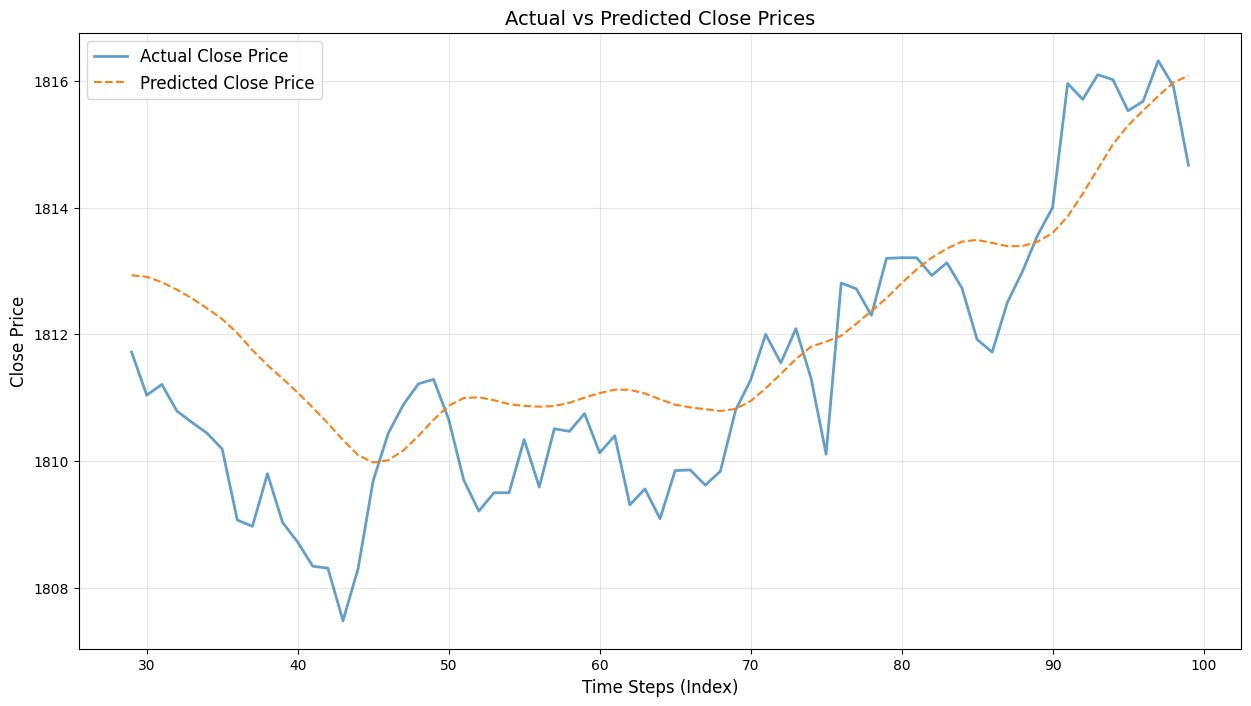

In [163]:
# Function to make predictions on new data
def predict_close_price(model, new_data, X_scaler, y_scaler, time_steps=30):

    # Set model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Scale the new data
    new_data_scaled = X_scaler.transform(new_data)
    
    # Create sequences for prediction
    sequences = []
    for i in range(len(new_data_scaled) - time_steps + 1):
        sequences.append(new_data_scaled[i:i+time_steps])
    
    # Convert to tensor
    sequences_tensor = torch.FloatTensor(sequences).to(device)
    
    # Make predictions
    with torch.no_grad():
        predicted_scaled = model(sequences_tensor).cpu().numpy()
    
    # Inverse transform the predictions
    predictions = y_scaler.inverse_transform(predicted_scaled)
    
    return predictions.flatten()

# Example of using the prediction function (assuming you have new data)
# This would be applied to your test/validation data
new_data = df[selected_features].values[-100:]  # Last 100 data points as an example
predictions = predict_close_price(trained_model, new_data, X_scaler, y_scaler)

# Get the corresponding actual close prices
# Remember predictions start at index = time_steps (due to sequence creation)
actual_close = df['close'].values[-len(predictions) - time_steps + 1:]

# Create time indices for proper alignment
time_indices = np.arange(len(actual_close))[-len(predictions):]

plt.figure(figsize=(15, 8))

# Plot actual prices for the relevant period
plt.plot(time_indices, actual_close[-len(predictions):], 
         label='Actual Close Price', alpha=0.7, linewidth=2)

# Plot predicted prices
plt.plot(time_indices, predictions, 
         label='Predicted Close Price', linestyle='--', linewidth=1.5)

plt.xlabel('Time Steps (Index)', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.title('Actual vs Predicted Close Prices', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()
